In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Load data

In [3]:
df_1min = load_pkl('/Users/matkovskiyivan/world/money/experiments/feat_engin//data/data_shift_time_1min.pkl')
# df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
# df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
# df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')

In [8]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-19')))

In [10]:
#Оставим каждый 1час
mask_freq_min = np.array(df_1min['time'].dt.minute == 0)

mask_train &= mask_freq_min
mask_valid &= mask_freq_min
mask_test &= mask_freq_min
mask_test2 &= mask_freq_min

In [13]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(36342, 8861, 9197, 7354)

In [15]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

61754

In [17]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.588496291738187,
 0.14348868089516467,
 0.14892962399196813,
 0.11908540337468018)

In [19]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

In [21]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.2074459303285455,
 0.2417334386638077,
 0.2741111231923453,
 0.2439488713625238)

In [28]:
# import keras

# model = keras.saving.load_model('./best_models/model_0004.keras',
#                                 custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})


# AUC_ROC:  [0.667, 0.581, 0.56, 0.588]
# PRECISION:  [0.455, 0.511, 0.461, 0.47]

# Evaluate

In [36]:
df = df_1min.copy()
df.head()

,time,close,volume,close_w1_roc,close_w1_diff,volume_w1_roc,volume_w1_diff,close_w60_ma,close_w60_std,close_w60_min,...,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target
index,,,,,,,,,,,,,,,,,,,,,
0,2022-10-03 10:01:00,219.929993,87793.0,NaN,NaN,NaN,NaN,219.929993,NaN,219.929993,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0
1,2022-10-03 10:02:00,220.800003,61549.0,0.003956,0.87,-0.298930,-26244.0,220.365005,0.615183,219.929993,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0
2,2022-10-03 10:03:00,219.339996,52640.0,-0.006612,-1.46,-0.144746,-8909.0,220.023331,0.734461,219.339996,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0
3,2022-10-03 10:04:00,218.960007,61506.0,-0.001732,-0.38,0.168427,8866.0,219.757507,0.801431,218.960007,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0
4,2022-10-03 10:05:00,218.300003,51464.0,-0.003014,-0.66,-0.163269,-10042.0,219.466003,0.952145,218.300003,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0


In [37]:
df['sample'] = None
df.loc[mask_valid, 'sample'] = 'valid'
df.loc[mask_test, 'sample'] = 'test'
df.loc[mask_test2, 'sample'] = 'test2'

### load data

In [45]:
#load data

y_pred_valid = load_pkl('./y_pred_valid.pkl')
y_pred_test = load_pkl('./y_pred_test.pkl')
y_pred_test2 = load_pkl('./y_pred_test2.pkl')


df['y_pred'] = None
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

In [47]:
# keras_0004: layer = 2, num_head=16, dim=128, dropout=0
# AUC_ROC:  [0.788, 0.57, 0.595, 0.587]
# PRECISION:  [0.714, 0.551, 0.587, 0.554]

### auc_roc

In [50]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.5704016189995371, 0.5950226604609953, 0.5873542303281121)

### target

In [54]:
q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

0.550561797752809
0.5869565217391305
0.5540540540540541


In [57]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

threshokd = 0.6190502285957336
0.550561797752809
0.5294117647058824
0.5357142857142857


### Посомтрим на вероятности

In [67]:
mask_freq_min = np.array(df['time'].dt.minute == 0)
df = df[mask_freq_min]
df.reset_index(inplace=True, drop=True)

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

In [69]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.5704016189995371, 0.5950226604609953, 0.5873542303281121)

38139 SNGS
25


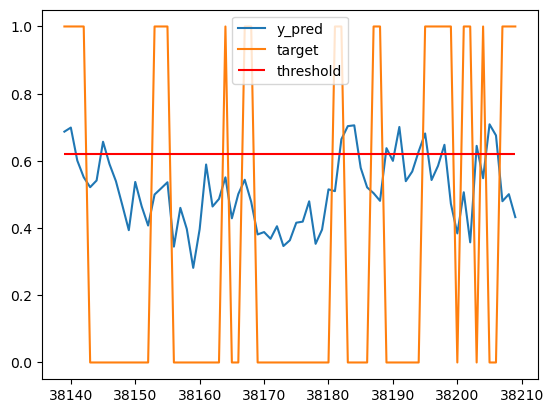

38256 SNGS
34


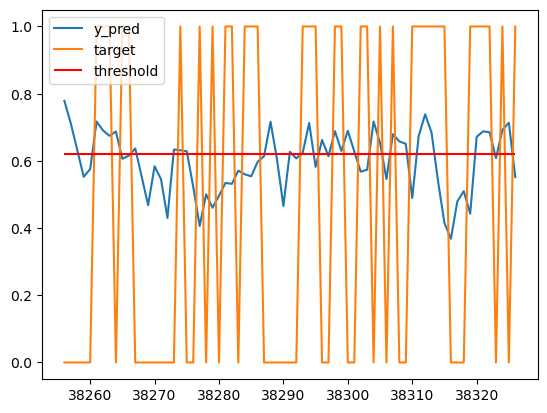

95790 MAGN
24


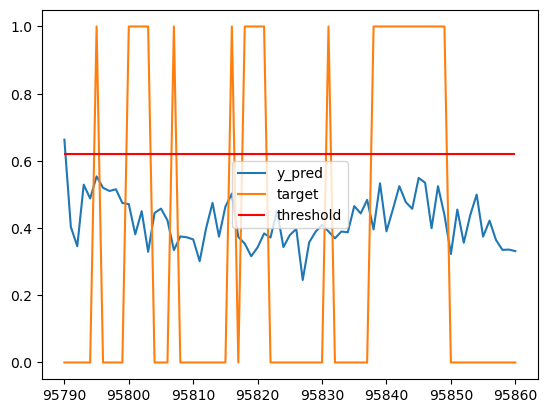

37873 SNGS
33


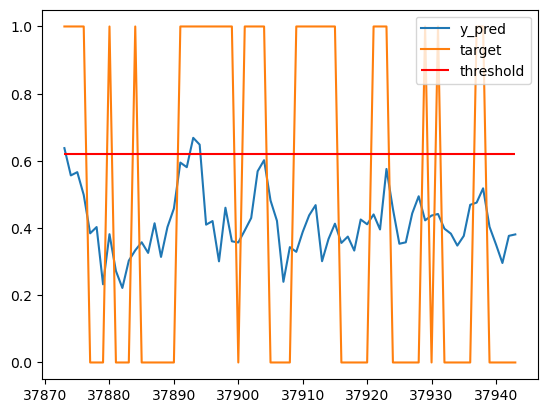

38448 SNGS
27


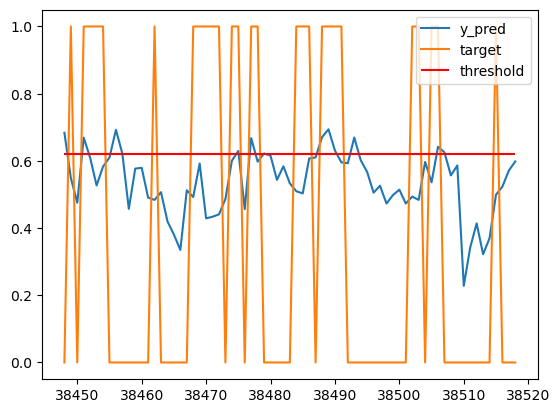

37631 SNGS
29


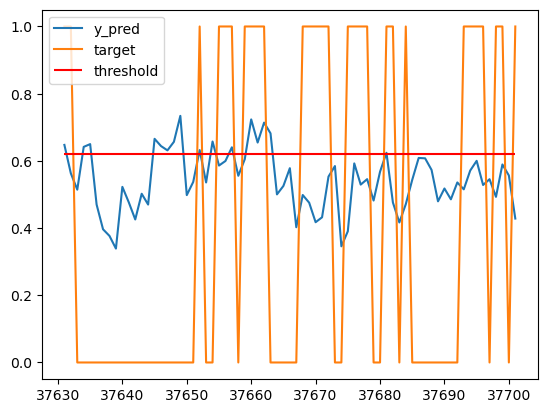

37765 SNGS
19


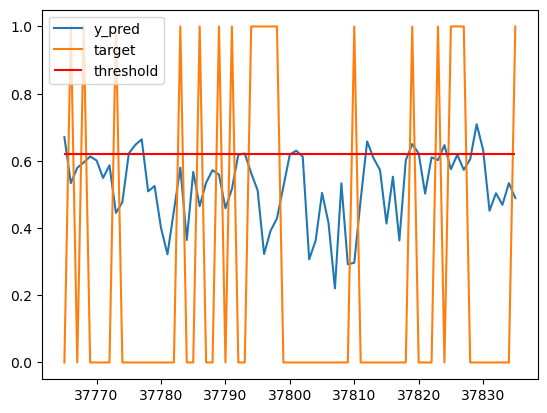

38802 SNGS
16


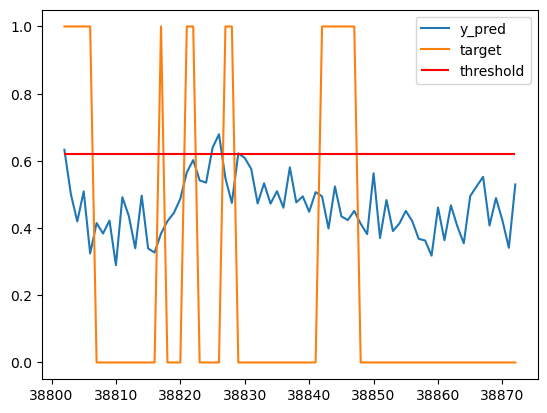

37647 SNGS
39


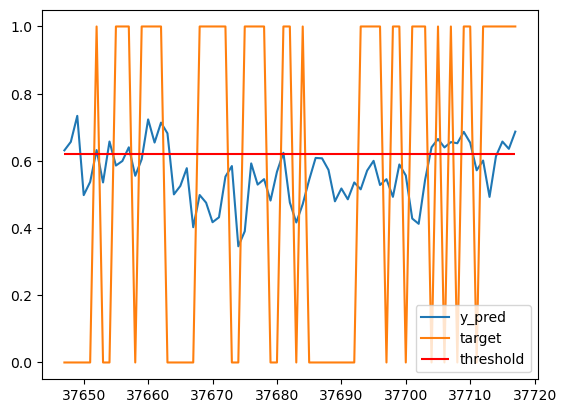

38386 SNGS
35


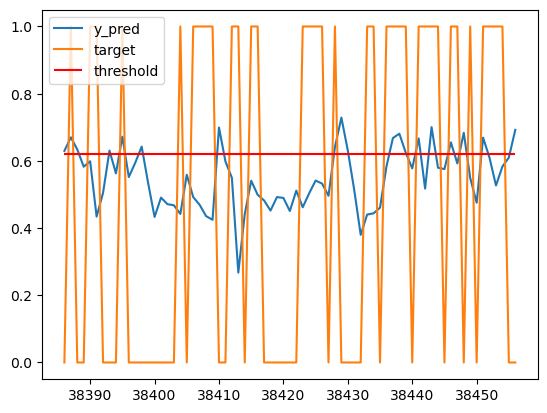

38053 SNGS
33


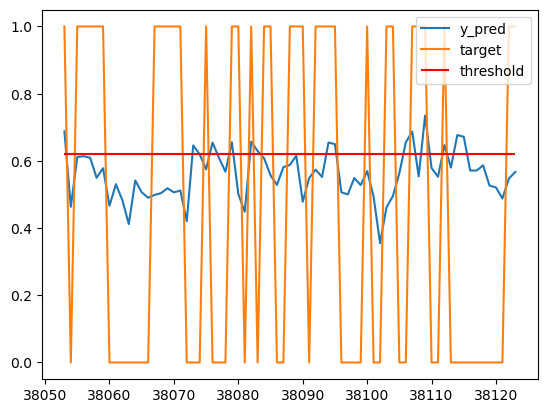

37820 SNGS
29


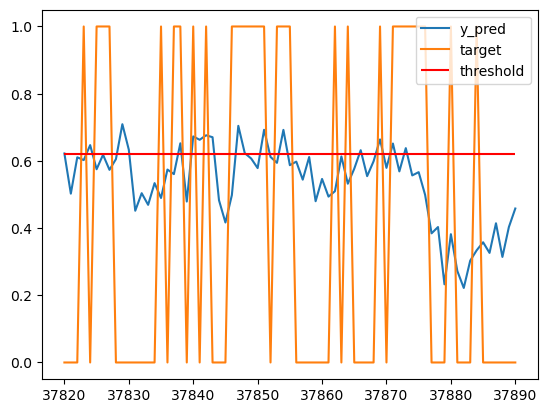

37581 SNGS
37


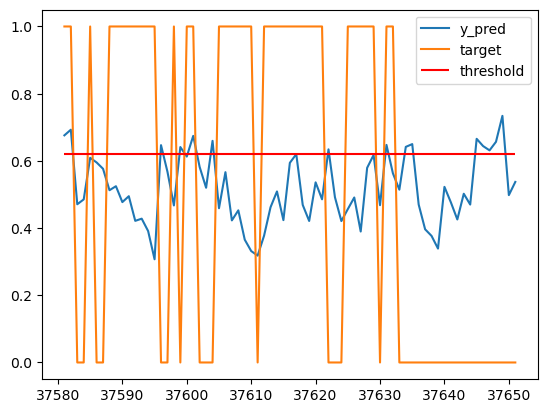

38183 SNGS
32


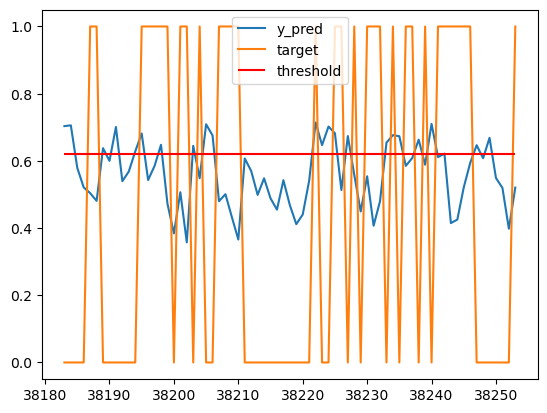

38203 SNGS
30


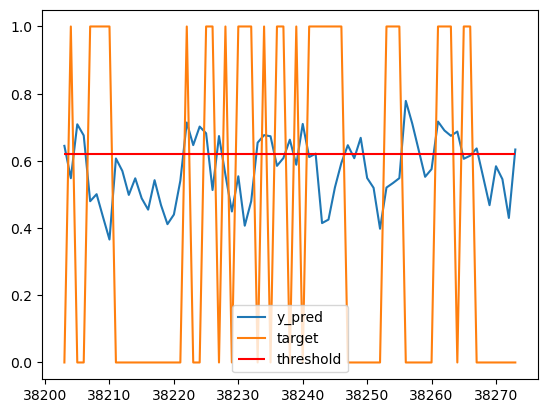

38223 SNGS
33


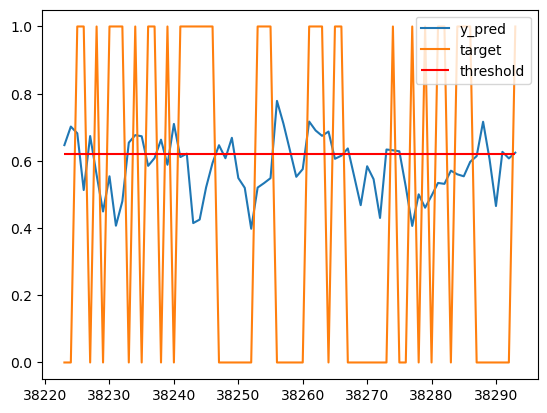

38112 SNGS
25


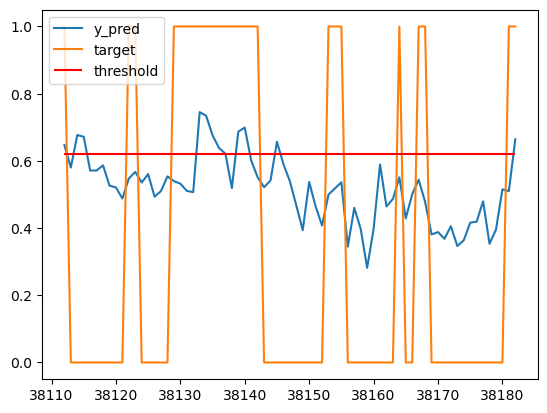

38145 SNGS
22


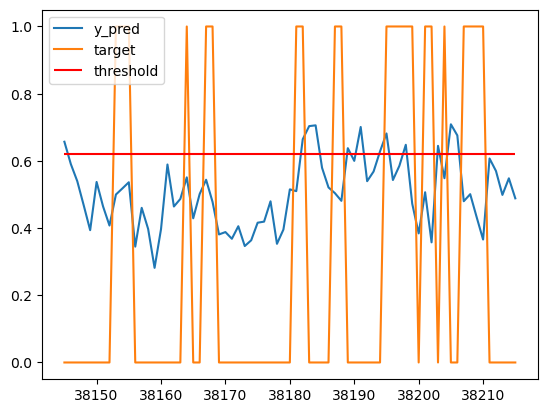

38430 SNGS
34


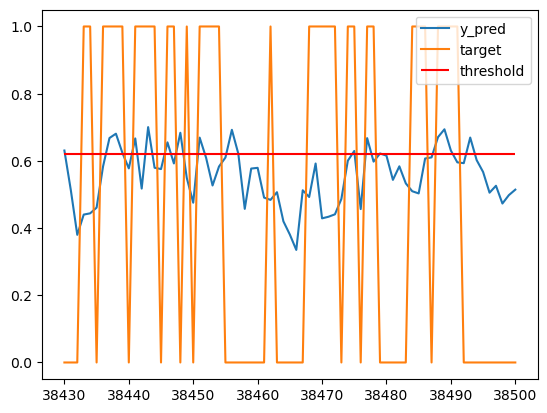

38076 SNGS
35


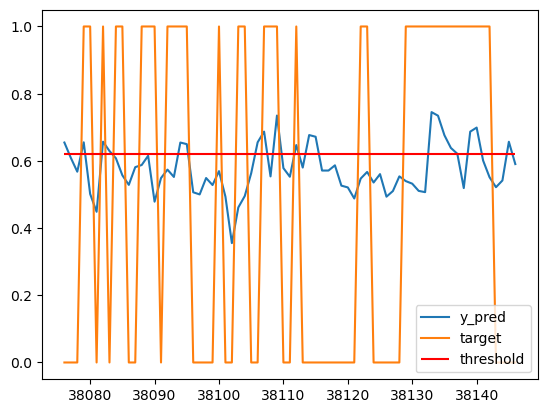

In [72]:
#bit threshold
mask = df['y_pred'] > threshold
inds = np.random.choice(df.index[(mask_valid|mask_test|mask_test2) & (mask)], size=20)



window = 14*5#неделя
for i in inds:
    print(i, df.loc[i, 'ticker'])
    print(df.loc[i:i+window, 'target'].sum())
    plt.plot(df.loc[i:i+window, 'y_pred'], label='y_pred')
    plt.plot(df.loc[i:i+window, 'target'], label='target')
    plt.hlines(threshold, i, i+window, color='red', label='threshold')
    plt.legend()
    plt.show()

### target24

In [79]:
# df

In [81]:
# df['result'].value_counts(normalize=True)

In [83]:
# df_result = load_pkl('./experiments/model_one_fc/df_result_wait_1day.pkl')
# df_result

In [85]:
# df_result['delta_time'] = df_result['delta_time'].replace(-1, pd.Timedelta('100 days'))
# mask = df_result['delta_time'] > pd.Timedelta('24 hours')
# df_result.loc[mask, 'result'] = 'DNF'

In [87]:
# df_result['result'].value_counts(normalize=True)

In [89]:
# df['target24'] = (df_result['result'] == 'WIN').astype(int)

In [92]:
# threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_valid&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test2&mask, 'target24'].mean())

### Распределение вероятностей в целом

In [97]:
import warnings
warnings.filterwarnings('ignore')


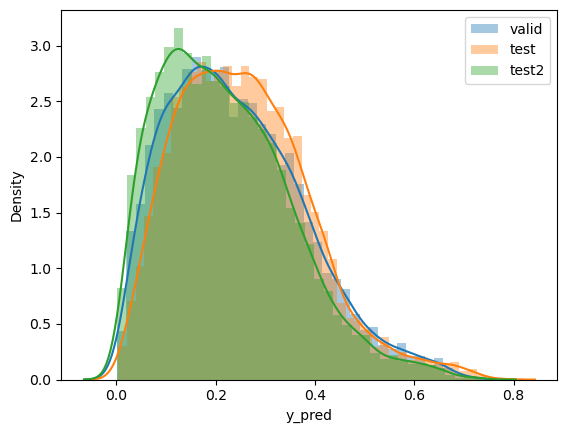

In [99]:

sns.distplot(df.loc[mask_valid, 'y_pred'], label='valid')
sns.distplot(df.loc[mask_test, 'y_pred'], label='test')
sns.distplot(df.loc[mask_test2, 'y_pred'], label='test2')
plt.legend()

In [100]:
#не так уж и плохо, есть надежды

### Распределение успеха (target) по бинам

[0.5771 0.6191]


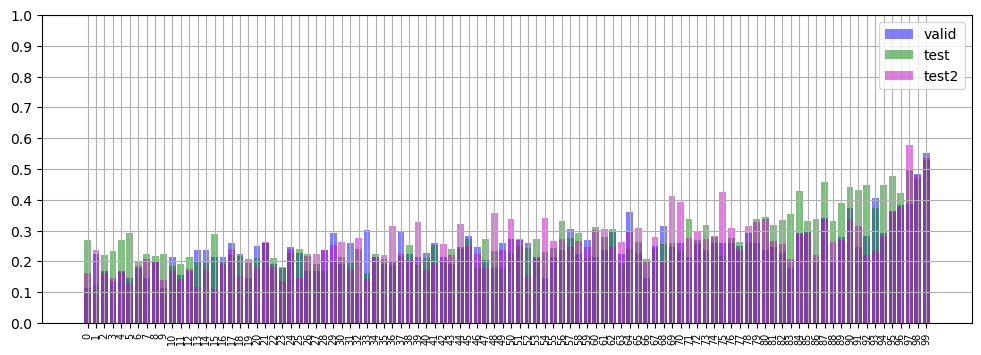

In [105]:
col_target = 'target'
q_count = 100



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


### Распределени успеха(target24) по бинам

In [110]:
# col_target = 'target24'
# q_count = 50

# print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

# df['bin'] = None

# df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
# q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
# df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


# df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
# df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


# df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
# df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

# plt.legend()
# plt.show()

In [112]:
pd.DataFrame(np.array([np.quantile(df.loc[mask_valid, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test2, 'y_pred'], q=np.arange(0.95, 1, 0.01))
                       
                      ]).T)

,0,1,2
0,0.493554,0.494908,0.459696
1,0.515469,0.51844,0.481014
2,0.543305,0.548479,0.502933
3,0.577085,0.592139,0.544843
4,0.61905,0.649869,0.601734
5,0.733955,0.778557,0.738096


In [114]:
#как-то через чур хорошо

### В разрезе тикеров (внутри каждого тикера своя вероятность)

In [118]:
def distplot(df, col_target=None, q_count=None):
    for ticker in df['ticker'].unique():
        print(ticker)
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'

        print(np.round(np.quantile(df_tk.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
        
        sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
        sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
        sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
        plt.legend()
        plt.show()



        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, labels=False)
        q = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)
        
        plt.figure(figsize=(12,4))

        df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
        plt.grid(visible=0.0001)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xticks(np.arange(q_count), rotation=90, size=7)
        plt.legend()
        plt.show()
        

### таргет

GAZP
[0.4225 0.4639]


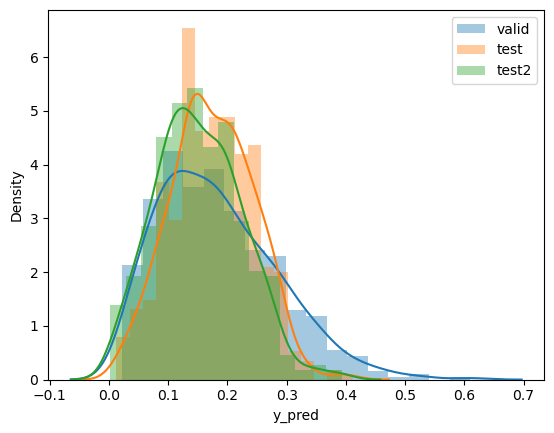

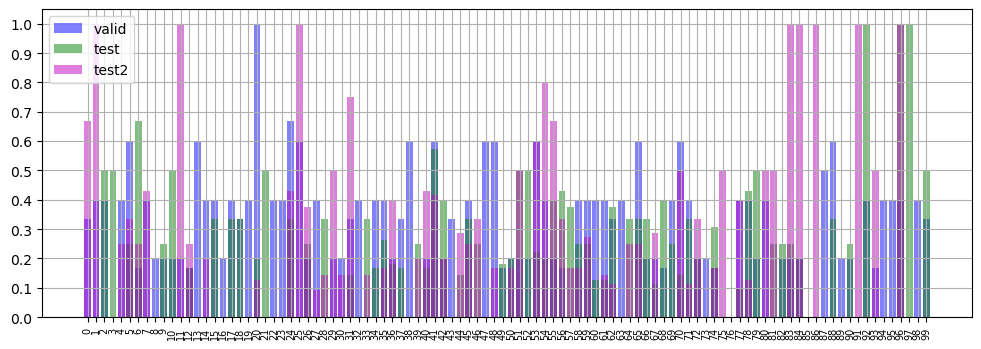

SBER
[0.2483 0.2737]


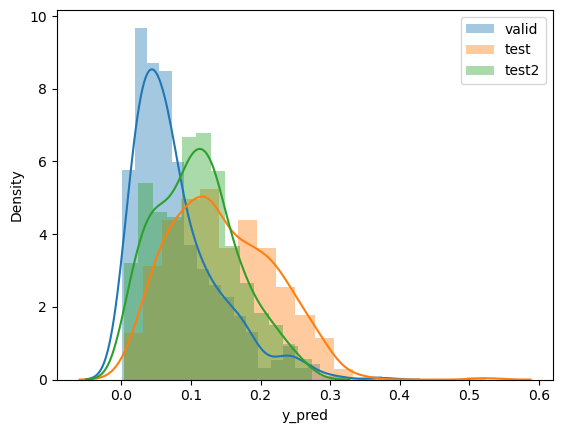

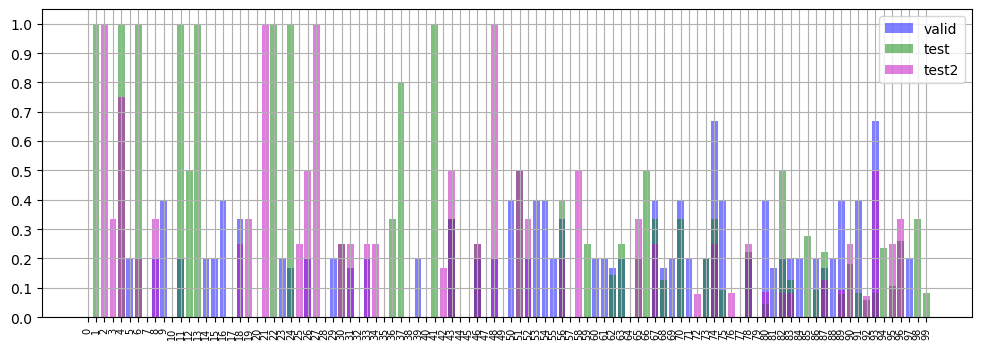

LKOH
[0.327  0.3578]


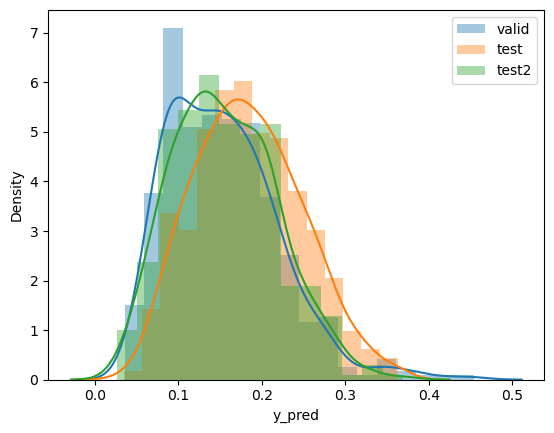

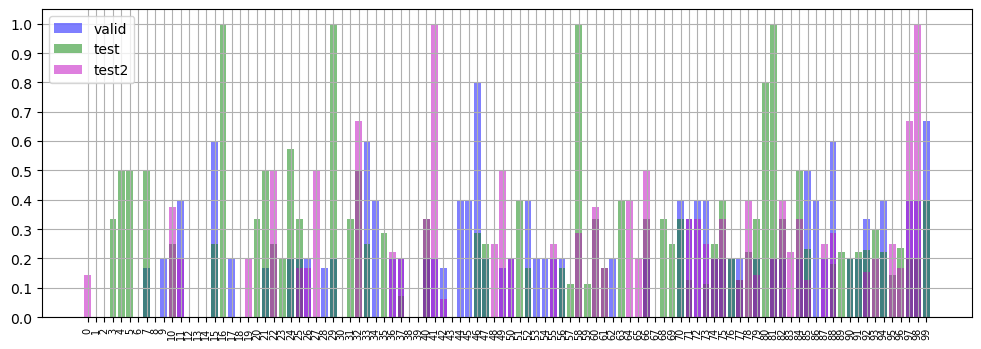

MGNT
[0.3903 0.4053]


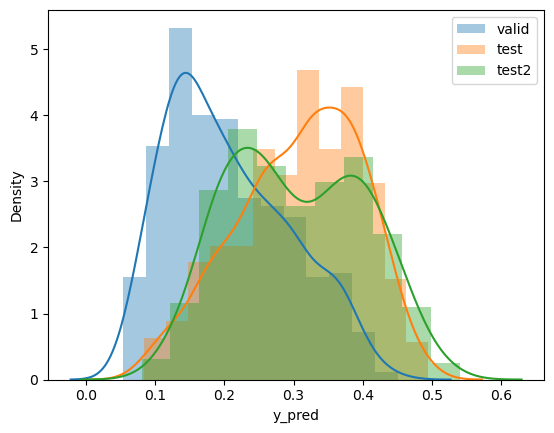

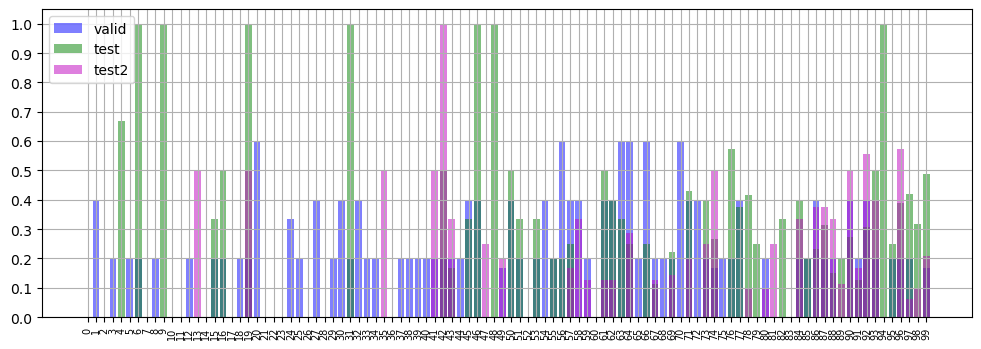

NVTK
[0.3471 0.3838]


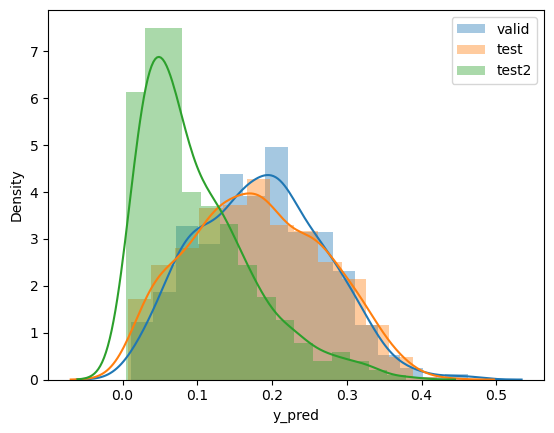

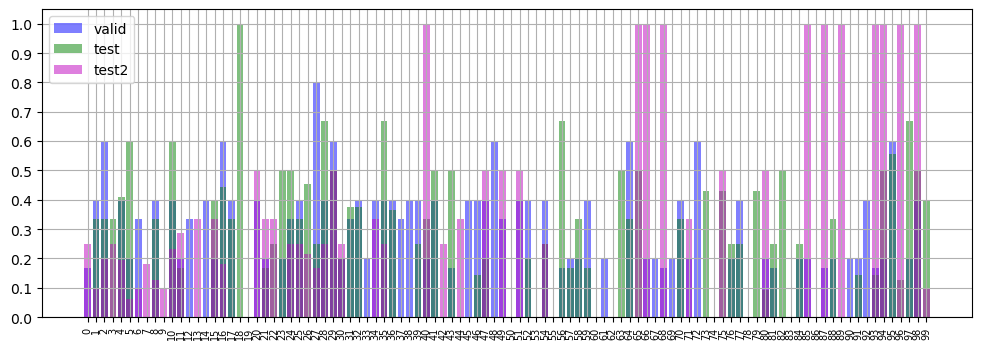

SNGS
[0.6914 0.7047]


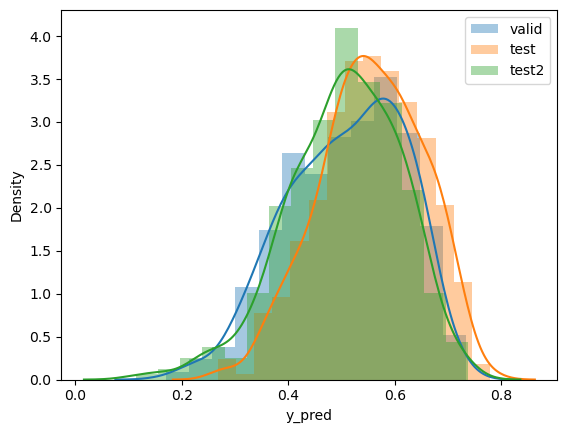

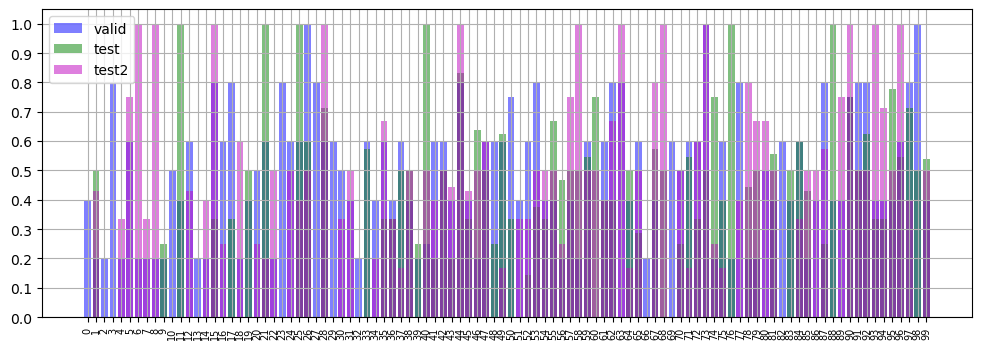

GMKN
[0.5495 0.5817]


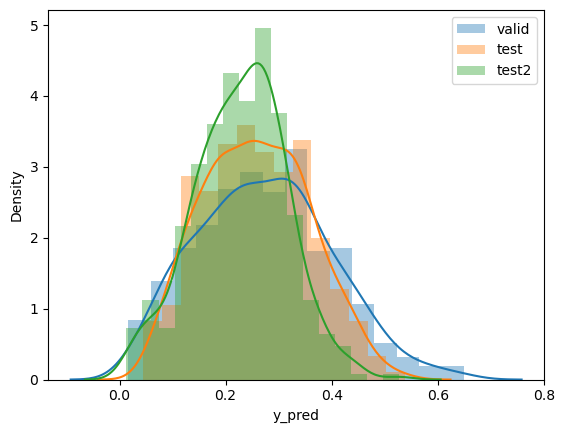

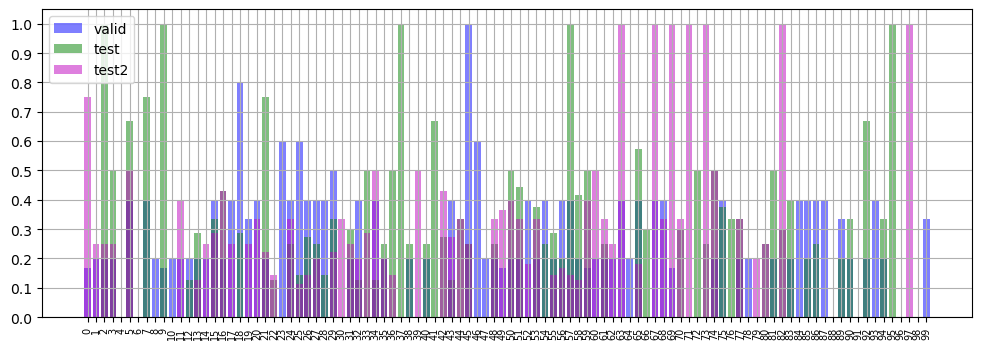

ROSN
[0.2796 0.3041]


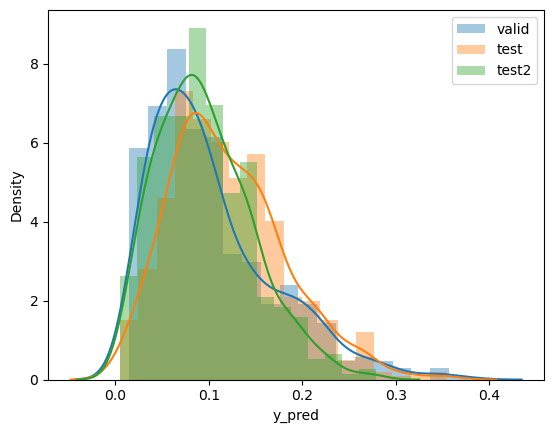

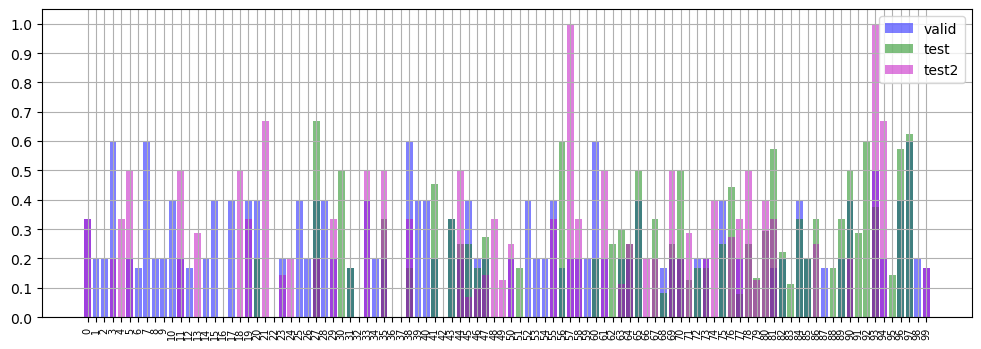

NLMK
[0.5143 0.5357]


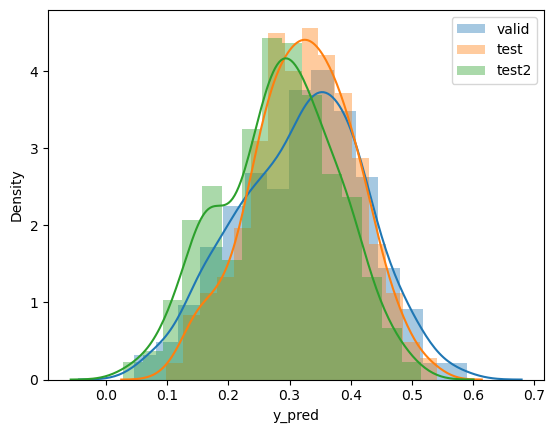

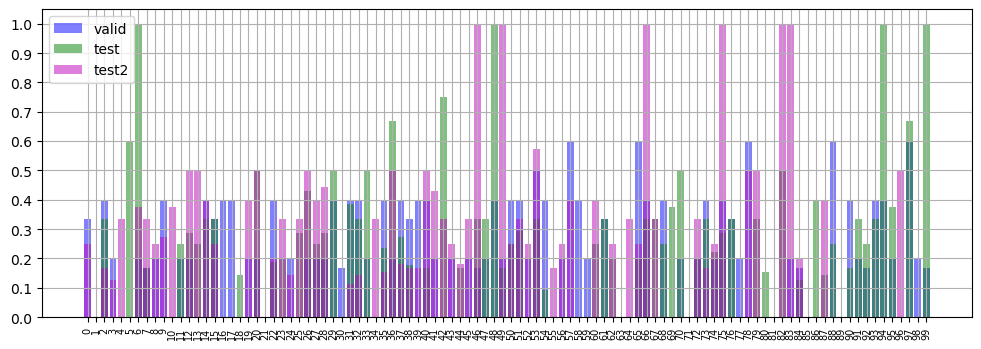

TATN
[0.4062 0.4343]


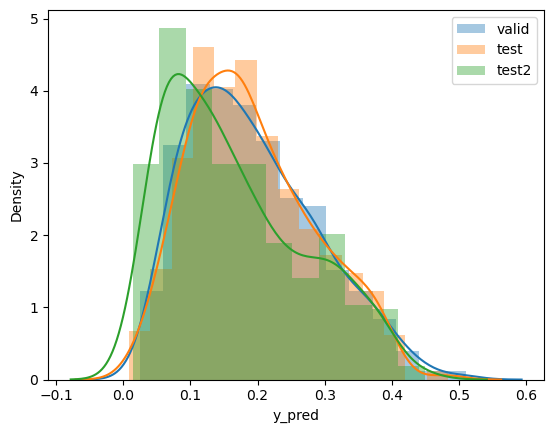

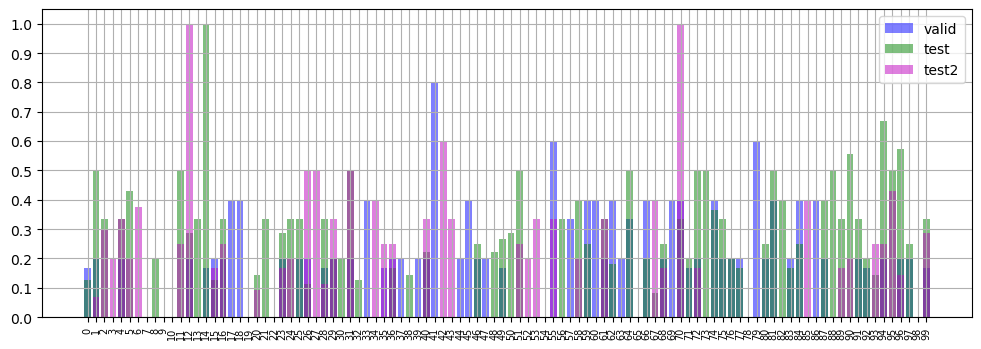

MTSS
[0.386  0.4621]


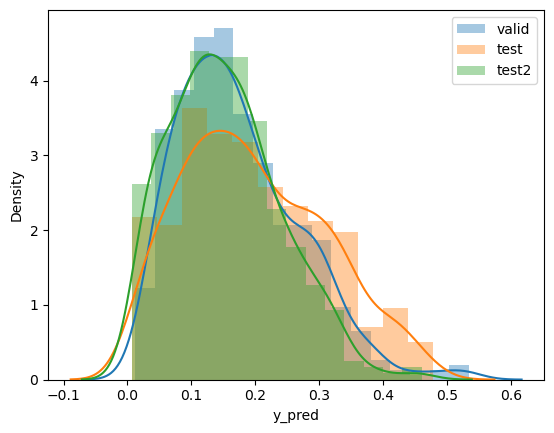

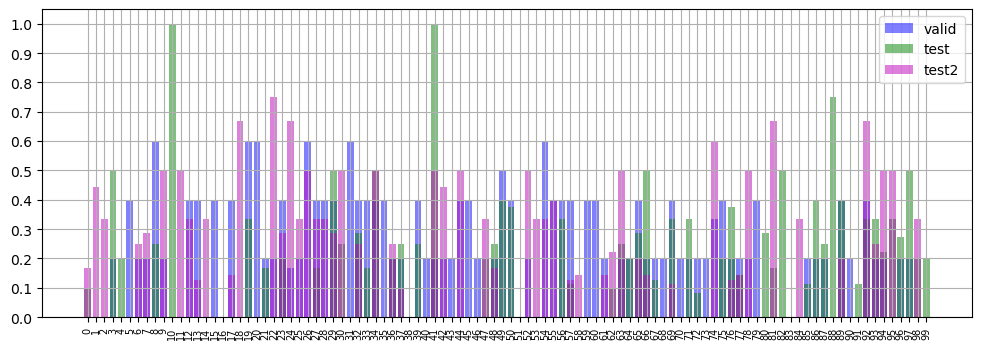

ALRS
[0.5524 0.5759]


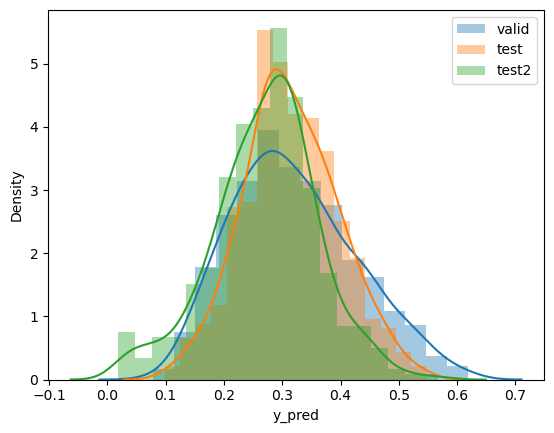

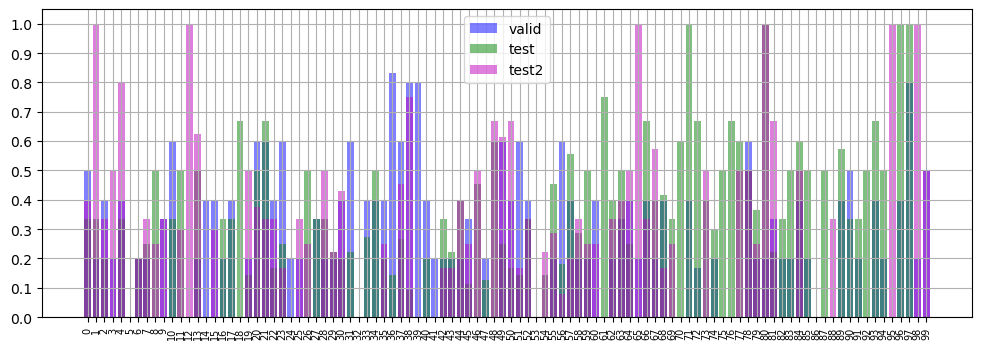

YDEX
[0.3777 0.4038]


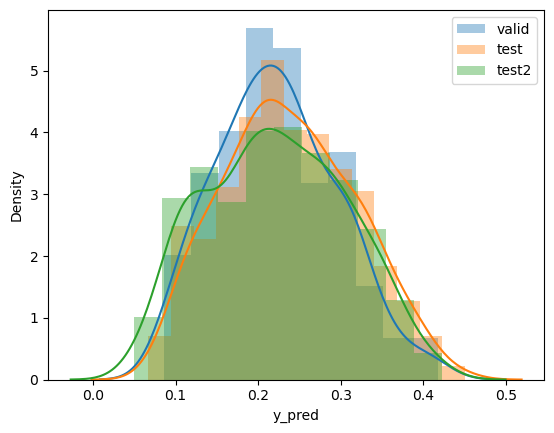

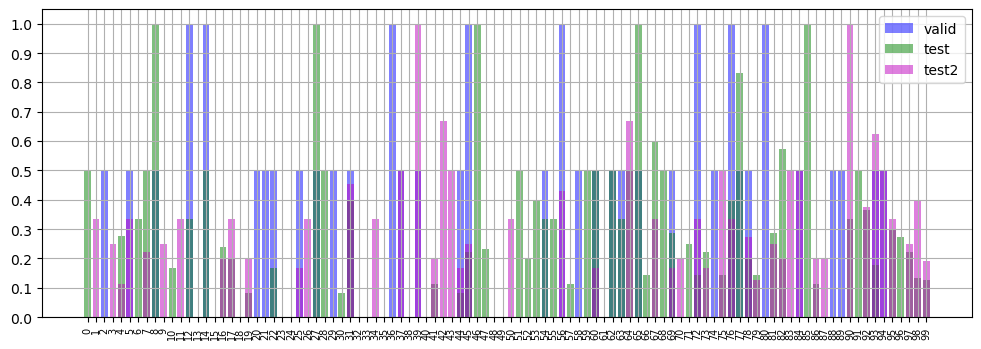

CHMF
[0.4155 0.4605]


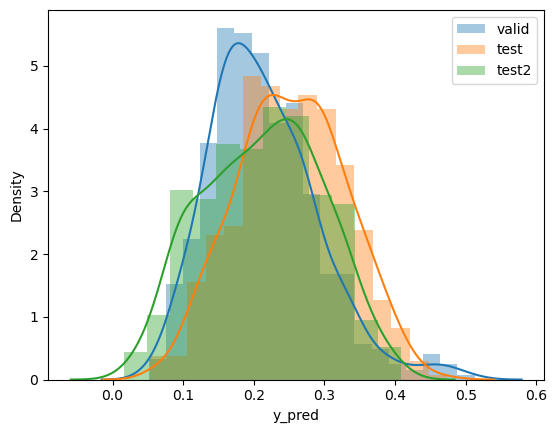

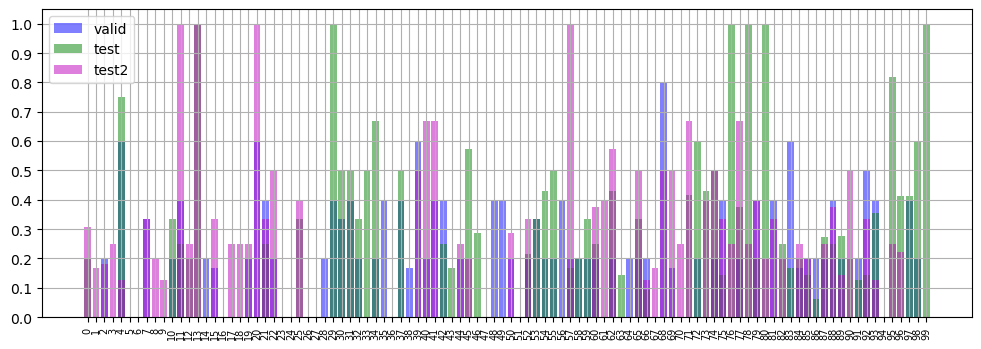

MAGN
[0.5591 0.58  ]


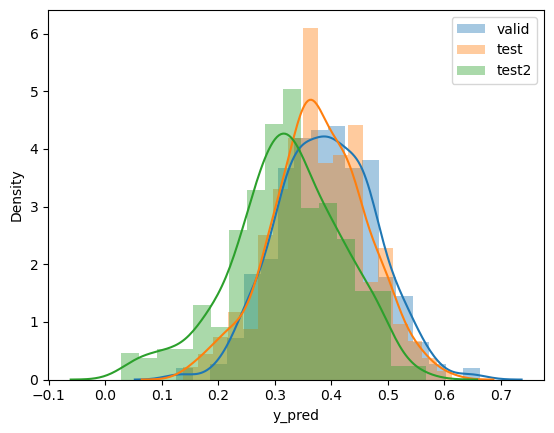

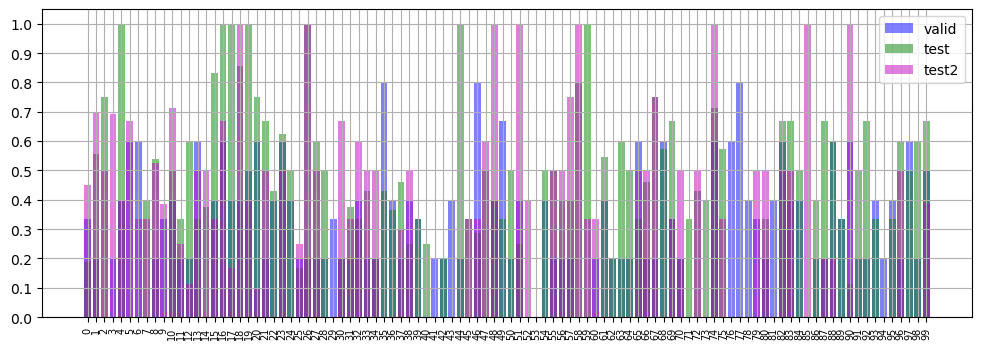

TCSG
[0.3487 0.359 ]


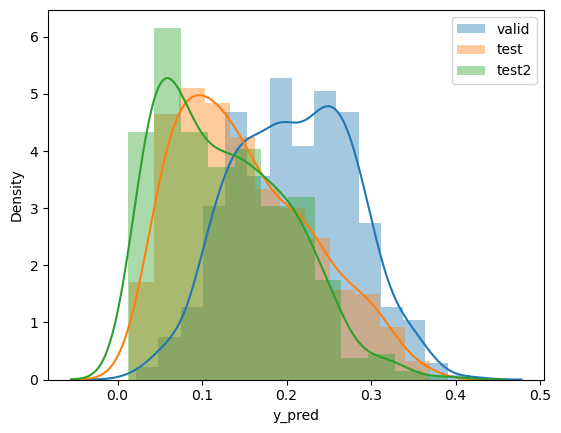

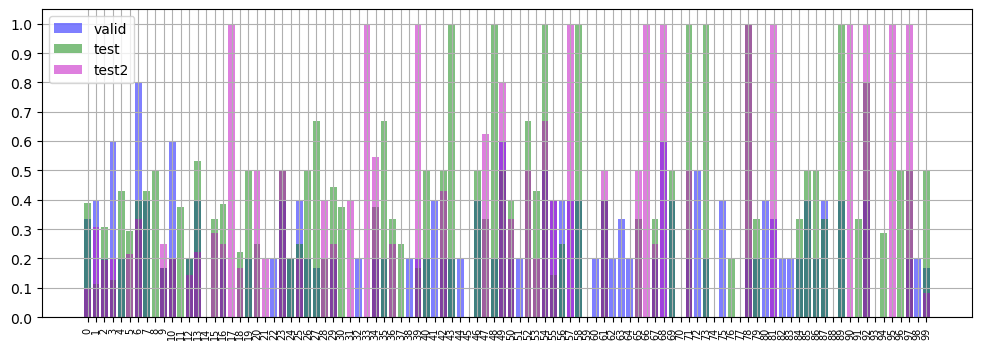

OZON
[0.4347 0.4396]


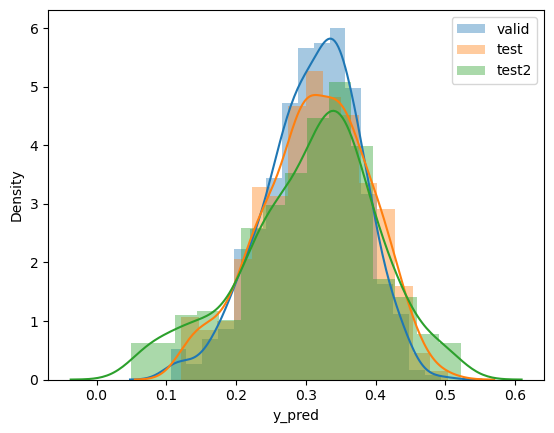

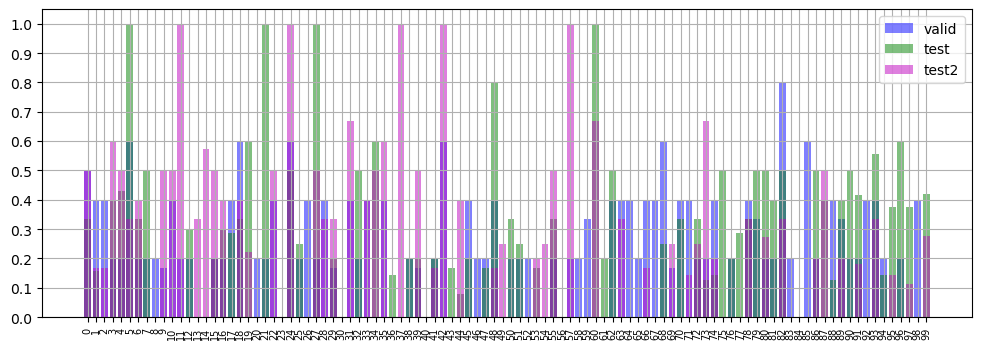

RUAL
[0.5126 0.5439]


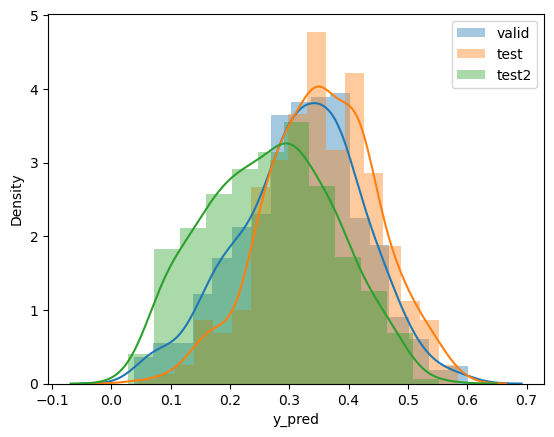

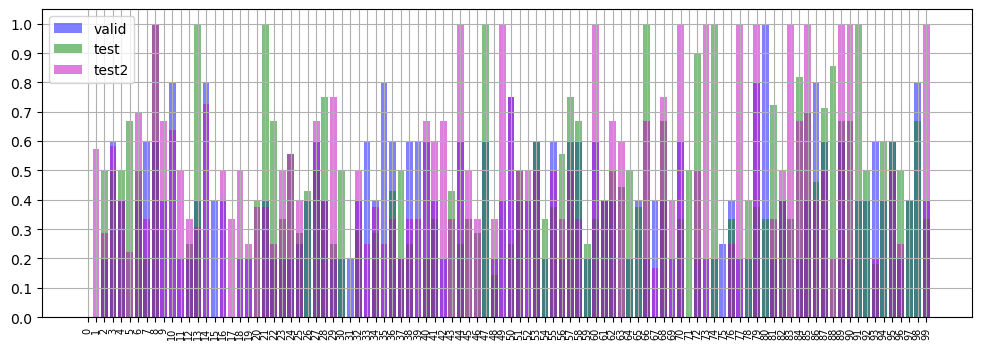

In [123]:
distplot(df, col_target='target',q_count=100)

In [124]:
#есть какие-то зацепки (Алроса, Магнит, СургутНГ)

### таргет24

In [128]:
#distplot(df, col_target='target24',q_count=50)

In [129]:
#Похоже, что искать свой попрог в каждой акции не лучшая идея

### Рассмотрим общий порог для всех акций

In [132]:
def distplot_common_threshold(df, col_target=None, q_count=None):

    mask_valid = df['sample'] == 'valid'
    q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
    
    for ticker in df['ticker'].unique():
        
        mask_valid = df['sample'] == 'valid'
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'
        




        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.cut(df_tk.loc[mask_valid, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_valid, 'bin'] = df_tk.loc[mask_valid, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

        if (df_tk['bin'] == q_count-1).sum() > 0:
            print(ticker)
            print(np.round(np.quantile(df.loc[df['sample'] == 'valid', 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
    

            
            sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
            sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
            sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
            plt.legend()
            plt.show()
        

            
        #print
            plt.figure(figsize=(12,4))
    
            df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
            plt.grid(visible=0.0001)
            plt.yticks(np.arange(0, 1.1, 0.1))
            plt.xticks(np.arange(q_count), rotation=90, size=7)
            plt.legend()
            plt.show()

            mask_last_bin = df_tk['bin'] == q_count-1
            print(f'PRECISION: {round(df_tk.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
        
        



        
        

### общий порог, таргет

SNGS
[0.5771 0.6191]


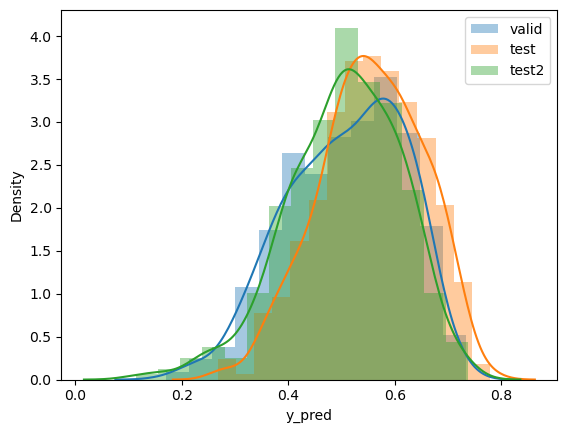

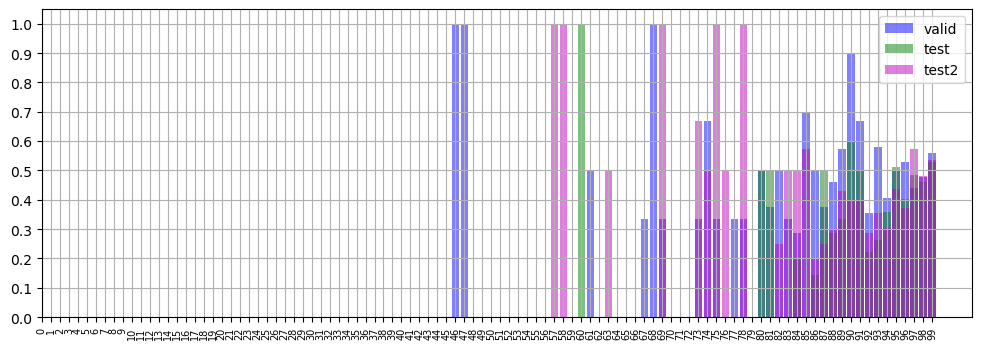

PRECISION: 0.56, 0.53, 0.54
GMKN
[0.5771 0.6191]


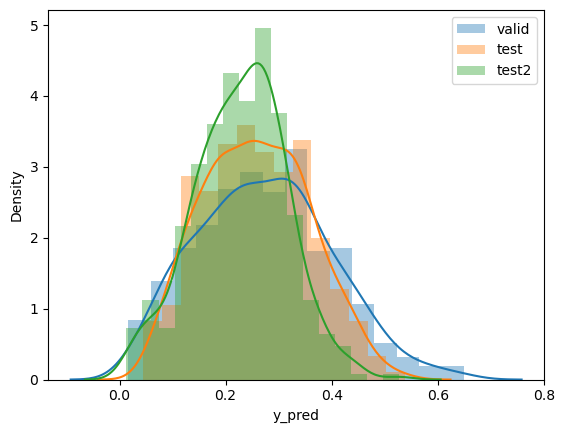

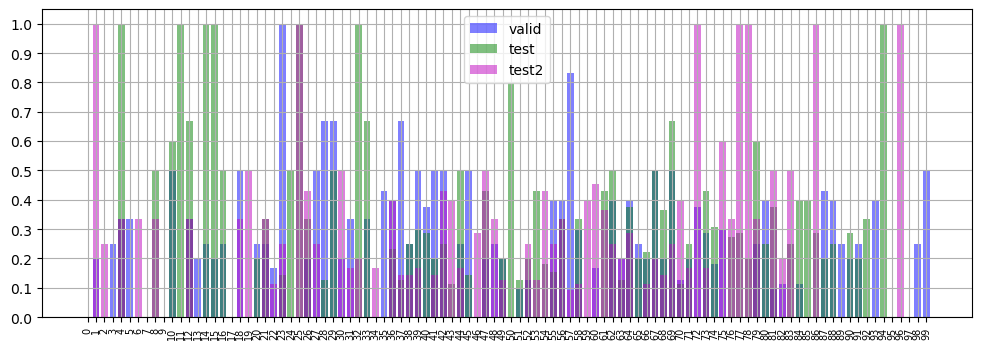

PRECISION: 0.5, nan, nan
MAGN
[0.5771 0.6191]


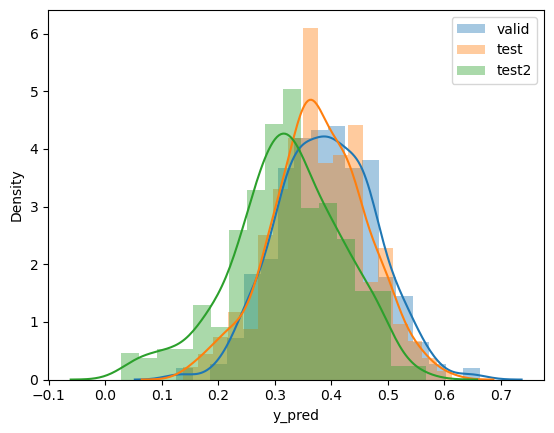

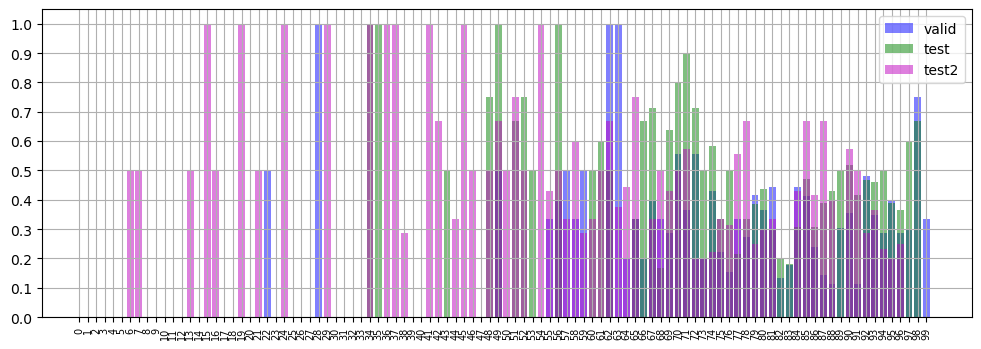

PRECISION: 0.33, nan, nan


In [136]:
distplot_common_threshold(df, col_target='target',q_count=100)

### общий порог, таргет12

In [143]:
# distplot_common_threshold(df, col_target='target24',q_count=50)

In [144]:
#тут результаты плохие в разрезе акций

# Донастройка

In [148]:
# По сути интересен только 99-перцентиль

In [158]:
#И точек норм, магия какая-то

In [160]:
q=0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.6190502285957336
89 0.550561797752809
92 0.5869565217391305
74 0.5540540540540541


In [135]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.6190502285957336
89 0.550561797752809
136 0.5294117647058824
56 0.5357142857142857


[0.5771 0.6191]


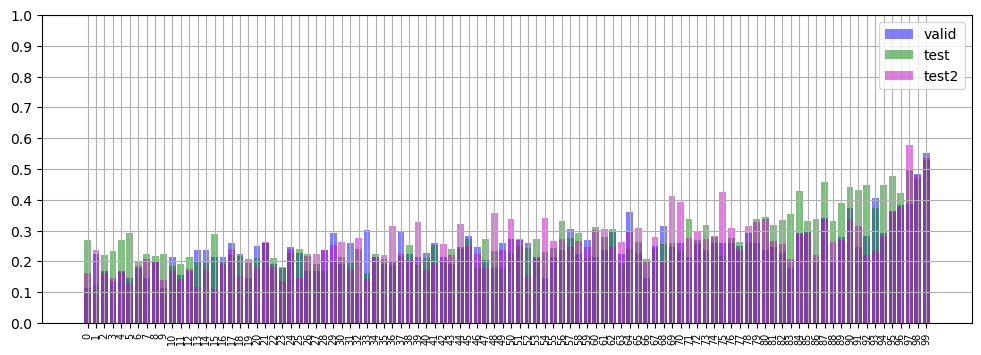

In [138]:
col_target = 'target'
q_count = 100



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


In [140]:
def exp_smoothing(df, col_target, alpha, q=0.99):
    mask = df['sample'].notnull()
    y_pred = np.array(df.loc[mask, 'y_pred']).copy()

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'
    
    for i in range(1, y_pred.shape[0]):
        y_pred[i] = (1-alpha)*y_pred[i-1] + alpha*y_pred[i]
    
    df['y_pred_exp'] = None
    df.loc[mask, 'y_pred_exp'] = y_pred


    
    threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=q)
    mask_last_bin = df['y_pred_exp'] > threshold
    
    print(f'ALPHA = {round(alpha,3)}, PRECISION: {round(df.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
    

### таргет

In [150]:
for alpha in np.arange(0.1, 1.1, 0.1):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.1, PRECISION: 0.71, 0.49, 0.28
ALPHA = 0.2, PRECISION: 0.64, 0.58, 0.38
ALPHA = 0.3, PRECISION: 0.64, 0.55, 0.38
ALPHA = 0.4, PRECISION: 0.64, 0.57, 0.44
ALPHA = 0.5, PRECISION: 0.64, 0.56, 0.42
ALPHA = 0.6, PRECISION: 0.6, 0.55, 0.47
ALPHA = 0.7, PRECISION: 0.62, 0.56, 0.59
ALPHA = 0.8, PRECISION: 0.62, 0.56, 0.63
ALPHA = 0.9, PRECISION: 0.62, 0.58, 0.63
ALPHA = 1.0, PRECISION: 0.62, 0.59, 0.63


In [171]:
# for alpha in np.arange(0.01, 1, 0.01):
#     exp_smoothing(df, 'target', alpha, q=0.99)

In [166]:
# for alpha in np.arange(0.005, 0.05, 0.005):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [167]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [ ]:
#ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56

In [ ]:
#И сколько их в день интересно? И на каких акциях?

In [ ]:
#Разные варианты

In [171]:
exp_smoothing(df, 'target', 1, q=0.98)

ALPHA = 1, PRECISION: 0.52, 0.51, 0.51


In [154]:
exp_smoothing(df, 'target', 1, q=0.99)

ALPHA = 1, PRECISION: 0.55, 0.53, 0.54


In [156]:
exp_smoothing(df, 'target', 1, q=0.995)


ALPHA = 1, PRECISION: 0.62, 0.59, 0.63


In [205]:
mask_valid = df['sample'] == 'valid'
threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=0.98)
threshold

0.5770845532417297

In [208]:
mask_threshold = df['y_pred_exp']  > threshold

mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_threshold].shape[0], df.loc[mask_test&mask_threshold].shape[0], df.loc[mask_test2&mask_threshold].shape[0]

(178, 217, 104)

In [210]:
df.loc[mask_valid&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_threshold, 'time'].dt.date.nunique()

(38, 41, 26)

In [212]:
df.loc[mask_valid&mask_threshold, 'ticker'].unique(), df.loc[mask_test&mask_threshold, 'ticker'].unique(), df.loc[mask_test2&mask_threshold, 'ticker'].unique()

(array(['GAZP', 'SNGS', 'GMKN', 'NLMK', 'ALRS', 'MAGN', 'RUAL'],
       dtype=object),
 array(['SNGS', 'MAGN', 'RUAL'], dtype=object),
 array(['SNGS'], dtype=object))

In [ ]:
#SGNS, MAGN, RUAL

In [ ]:
#Разъеб!!!

### Качество во времени

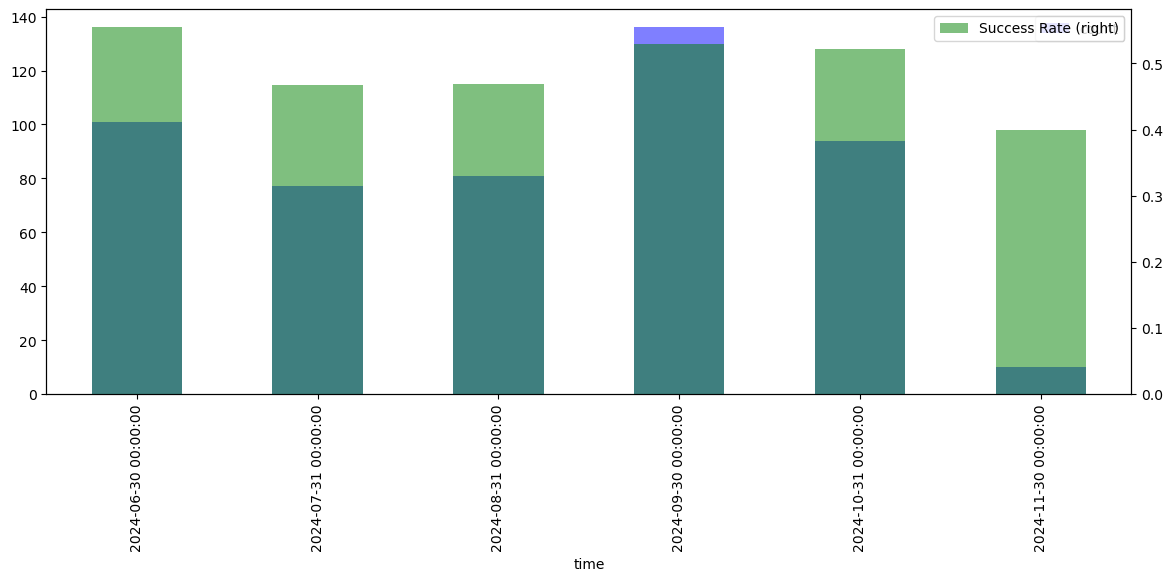

In [446]:
#distibution in timed

q = 0.98
freq='ME'

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask_last_bin = df['y_pred'] > threshold

mask_data = mask_valid|mask_test|mask_test2
plt.figure(figsize=(14, 5))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()

In [460]:
(0.4*1.4 - 0.6*0.6)*20

3.999999999999999

In [462]:
(0.5*1.4 - 0.5*0.6)*20

7.999999999999999

### Качество при 2-3 сигнала подряд за несколько часов

In [352]:
def precision_repeat_signal(df, col_target=None, signals=None, window=None, q=None):

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'


    threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
    mask = df['sample'].notnull()
    y_bin = np.array(df.loc[mask, 'y_pred'] > threshold).astype(int).copy()
    
    y_signals_window = np.zeros(y_bin.shape[0])
    for i in range(window-1, y_bin.shape[0]):
        y_signals_window[i] = y_bin[i-window+1:i+1].sum()
    
    df['y_signals_window'] = None
    df.loc[mask, 'y_signals_window'] = y_signals_window

    mask_signals = np.array(df['y_signals_window'] >= signals)
    
    print(f'SIGNALS = {signals}, WINDOW = {window}, PRECISION: {round(df.loc[mask_valid&mask_signals, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_signals, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_signals, col_target].mean(), 2)}')
    

In [355]:
signals_s = [2,3]
windows = [2,3,4,5]
for window in windows:
    for signals in signals_s:
        if signals <= window:
            precision_repeat_signal(df, col_target='target', signals=signals, window=window, q=0.98)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.54, 0.5, 0.52
SIGNALS = 2, WINDOW = 3, PRECISION: 0.49, 0.5, 0.51
SIGNALS = 3, WINDOW = 3, PRECISION: 0.54, 0.52, 0.44
SIGNALS = 2, WINDOW = 4, PRECISION: 0.48, 0.47, 0.52
SIGNALS = 3, WINDOW = 4, PRECISION: 0.53, 0.52, 0.46
SIGNALS = 2, WINDOW = 5, PRECISION: 0.48, 0.45, 0.5
SIGNALS = 3, WINDOW = 5, PRECISION: 0.52, 0.48, 0.46


In [357]:
signals_s = [2,3]
windows = [2,3,4,5]
for window in windows:
    for signals in signals_s:
        if signals <= window:
            precision_repeat_signal(df, col_target='target', signals=signals, window=window, q=0.99)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.51, 0.55, 0.48
SIGNALS = 2, WINDOW = 3, PRECISION: 0.51, 0.55, 0.43
SIGNALS = 3, WINDOW = 3, PRECISION: 0.53, 0.53, 0.44
SIGNALS = 2, WINDOW = 4, PRECISION: 0.51, 0.53, 0.45
SIGNALS = 3, WINDOW = 4, PRECISION: 0.48, 0.52, 0.4
SIGNALS = 2, WINDOW = 5, PRECISION: 0.52, 0.49, 0.47
SIGNALS = 3, WINDOW = 5, PRECISION: 0.52, 0.54, 0.38


In [359]:
signals_s = [2,3]
windows = [2,3,4,5]
for window in windows:
    for signals in signals_s:
        if signals <= window:
            precision_repeat_signal(df, col_target='target', signals=signals, window=window, q=0.995)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.57, 0.62, 0.64
SIGNALS = 2, WINDOW = 3, PRECISION: 0.58, 0.61, 0.5
SIGNALS = 3, WINDOW = 3, PRECISION: 0.57, 0.53, 0.67
SIGNALS = 2, WINDOW = 4, PRECISION: 0.55, 0.6, 0.46
SIGNALS = 3, WINDOW = 4, PRECISION: 0.43, 0.62, 0.55
SIGNALS = 2, WINDOW = 5, PRECISION: 0.61, 0.56, 0.47
SIGNALS = 3, WINDOW = 5, PRECISION: 0.42, 0.62, 0.5


In [361]:
# Подряд сигналы не усиливают precision

In [364]:
#а если порог ослабить

signals_s = [2,3]
windows = [2,3,4,5]
for window in windows:
    for signals in signals_s:
        if signals <= window:
            precision_repeat_signal(df, col_target='target', signals=signals, window=window, q=0.95)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.48, 0.5, 0.49
SIGNALS = 2, WINDOW = 3, PRECISION: 0.45, 0.48, 0.49
SIGNALS = 3, WINDOW = 3, PRECISION: 0.51, 0.49, 0.51
SIGNALS = 2, WINDOW = 4, PRECISION: 0.44, 0.47, 0.48
SIGNALS = 3, WINDOW = 4, PRECISION: 0.49, 0.48, 0.52
SIGNALS = 2, WINDOW = 5, PRECISION: 0.43, 0.47, 0.47
SIGNALS = 3, WINDOW = 5, PRECISION: 0.48, 0.47, 0.5


##### (2, 2)

In [400]:
precision_repeat_signal(df, col_target='target', signals=2, window=2, q=0.95)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.48, 0.5, 0.49


In [402]:
mask_signal = df['y_signals_window'] >= 2

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_signal].shape[0], df.loc[mask_test&mask_signal].shape[0], df.loc[mask_test2&mask_signal].shape[0]

(268, 344, 173)

In [404]:
#кол-во разных дней
df.loc[mask_valid&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_signal, 'time'].dt.date.nunique()

(37, 42, 30)

In [406]:
#кол-во разных тикеров
df.loc[mask_valid&mask_signal, 'ticker'].unique(), df.loc[mask_test&mask_signal, 'ticker'].unique(), df.loc[mask_test2&mask_signal, 'ticker'].unique()

(array(['GAZP', 'SNGS', 'GMKN', 'NLMK', 'ALRS', 'MAGN', 'RUAL'],
       dtype=object),
 array(['SNGS', 'NLMK', 'ALRS', 'MAGN', 'RUAL'], dtype=object),
 array(['SNGS', 'ALRS', 'OZON'], dtype=object))

##### (3, 3)

In [411]:
precision_repeat_signal(df, col_target='target', signals=3, window=3, q=0.95)

SIGNALS = 3, WINDOW = 3, PRECISION: 0.51, 0.49, 0.51


In [413]:
mask_signal = df['y_signals_window'] >= 3

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_signal].shape[0], df.loc[mask_test&mask_signal].shape[0], df.loc[mask_test2&mask_signal].shape[0]

(197, 287, 144)

In [415]:
#кол-во разных дней
df.loc[mask_valid&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_signal, 'time'].dt.date.nunique()

(35, 40, 26)

In [417]:
#кол-во разных тикеров
df.loc[mask_valid&mask_signal, 'ticker'].unique(), df.loc[mask_test&mask_signal, 'ticker'].unique(), df.loc[mask_test2&mask_signal, 'ticker'].unique()

(array(['GAZP', 'SNGS', 'GMKN', 'NLMK', 'ALRS', 'MAGN', 'RUAL'],
       dtype=object),
 array(['SNGS', 'MAGN', 'RUAL'], dtype=object),
 array(['SNGS', 'OZON'], dtype=object))

### Качество во времени (2,2)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.48, 0.5, 0.49


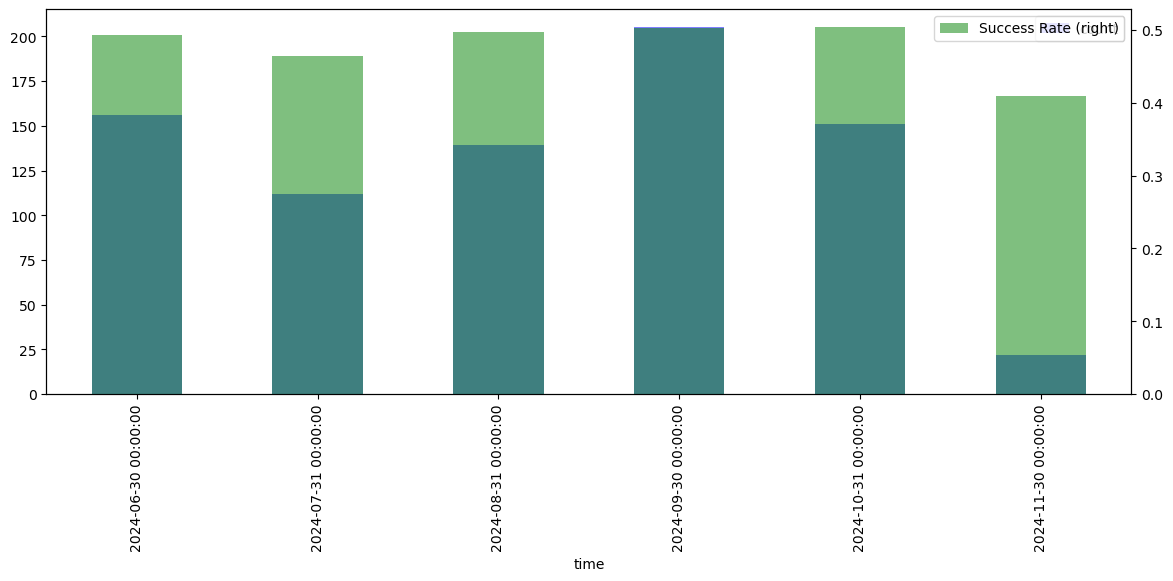

In [440]:
#distibution in timed

freq='ME'

precision_repeat_signal(df, col_target='target', signals=2, window=2, q=0.95)
mask_signal = df['y_signals_window'] >= 2

mask_data = mask_valid|mask_test|mask_test2

plt.figure(figsize=(14, 5))
df.loc[mask_data&mask_signal, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_signal, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()

In [389]:
#А вот это уже интереcнее

### таргет (доп для моделей <1 дня)

In [148]:
# for alpha in np.arange(0.1, 1.1, 0.1):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [150]:
# for alpha in np.arange(0.01, 0.11, 0.01):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [152]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [ ]:
#ALPHA = 0.005, PRECISION: 0.53, 0.55, 0.58